<a href="https://colab.research.google.com/github/pamelasschlegel/Predicting-Heart-Disease-with-Machine-Learning/blob/main/Predicting_Cardiovascular_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Cardiovascular Disease with a Machine Learning Model


---

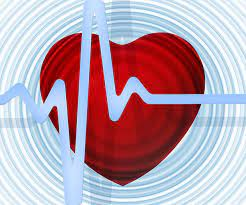


According to the American Heart Association, heart disease remains the number one cause of death in the United States according to 2020 data.The estimated direct and indirect cost of heart disease in 2018 to 2019 (average annual) was $239.9 billion in the United States.

source: American Heart Association 2023 Statistics [link to source](https://professional.heart.org/en/science-news/heart-disease-and-stroke-statistics-2023-update)

> My interest in the health field and personal experience with loved ones having cardiovascular disease were the driving forces in choosing this topic for a machine learning model. I chose a dataset that had both clinical continuous values (age, height, weight, systolic and diastolic blood pressure measurements) and behavioral categorical boolean values (smoking, alcohol consumption, activity level). The dataset also included ordinal encoded categorical fields for cholesterol level and glucose level. I feel including both behavior and medical vitals will give a more complete picture of health for the machine learning model.  

 I envision a physicians office using this model to input patient information during intake for a visit. Hopefully, the model would return an accurate predication as to whether a patient has heart disease so that additional cardiological testing/evaluation could be done to catch new heart disease earlier. The model’s prediction could also be used to reduce unnecessary cardiovascular testing for patients which would support patient and insurance savings.






# Risk Factors for Cardiovascular Heart Disease Dataset - Kaggle [[source]](https://www.kaggle.com/datasets/thedevastator/exploring-risk-factors-for-cardiovascular-diseas)
This dataset contains detailed information on the risk factors for cardiovascular disease. It includes information on age, gender, height, weight, blood pressure values, cholesterol levels, glucose levels, smoking habits and alcohol consumption of over 70 thousand individuals. Additionally it outlines if the person is active or not and if he or she has any cardiovascular diseases.

Data Dictionary - Dataset Features

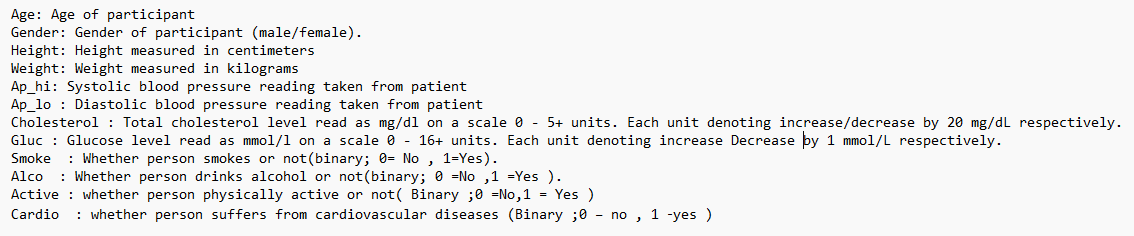

Importing Libraries for use in analysis, model building, and evaluation.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for data visuals
import seaborn as sns # for data visuals
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score # for finding validation set accuracy
from sklearn.linear_model import LogisticRegression # for trying a logistic regression model
from sklearn.tree import DecisionTreeClassifier # for trying a decision tree model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier # for trying advanced decsion tree models
from sklearn.model_selection import GridSearchCV # for tuning hyperparameters
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score,recall_score, roc_auc_score # for defining performance of a classification model

Reading the data into a pandas dataframe and viewing the top five rows of data.

In [2]:
heart_data = pd.read_csv('/content/heart data.csv') # loading data into pandas dataframe
heart_data.head()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Some things noted about the dataset upon viewing first five rows of data. 
1. The age column seems to have a unit of days.This would put our range in the age field between 29-65 years old. This seems reasonable and in line with the dataset description given on Kaggle.
2. The gender column is encoded with 1 for male and 2 for female.
3. Height and weight columns are in cm and kg respectively.
4. The behavioral categories (smoke, alcohol, active) have already been encoded with 0 for false and 1 for true for the behavior.
5. The cholesterol and glucose columns have ordinal encoded data. Upon initial inspection, they look to be enoded with values of  1,2 or 3. I will verify this using value_counts() in a later step.
6. The index and id columns contain unique values and therefore are not needed and will be dropped.
7. The columns contain a wide range of values so I may want to normalize my data before training my machine learning model. Decision trees typically don't need normalized data, but I will investigate the accuracy both with and without normalization.
8. I have a target feature named cardio which is a boolean encoded data type.





Investigating shape, columns and datatypes in our dataset.

In [3]:
heart_data.shape # finding number of observations and features in dataframe

(70000, 14)

In [4]:
heart_data.columns # viewing columns

Index(['index', 'id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [5]:
heart_data.duplicated().sum() # checking for duplicate rows

0

In [6]:
heart_data.info() # looking at data types and checking number of nulls in each field

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        70000 non-null  int64  
 1   id           70000 non-null  int64  
 2   age          70000 non-null  int64  
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  int64  
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  int64  
 7   ap_lo        70000 non-null  int64  
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.5 MB


We know that we have 70000 rows of data from running .shape on our dataframe. We can see from .info() that we have no nulls in this dataframe. Nice!

In [7]:
heart_data.describe() # getting a sense of our data and looking for data inconsistencies

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,20207.403759,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.750000,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,34999.500000,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,52499.250000,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,69999.000000,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


###Data Wrangling


*  Dropping columns we do not need which were identified earlier 
as the 'index' and 'id' columns.
*   Converting the 'age' column to years. This will help to bring the values closer to other values in the dataset and is just plain easier to work with as it is the units we usually work in with age.
*   Converting height and weight columns to US units of feet and pounds respectively for ease of interpreting and they are the units of measures used in the US for these features.
*   Changing the encoding in the gender field to 0 for male, 1 for female for consistency within the dataset.










In [3]:
heart_data = heart_data.drop(['index','id'], axis=1) # dropping irrelevant columns

In [4]:
heart_data['age'] = round((heart_data['age']/365),2) # converting age in days to years and rounding to two decimal places

In [5]:
# heart_data['height'] = round((heart_data['height']*0.0328084),2) # converting height to feet
heart_data['height'] = round((heart_data['height']/2.54),2) # converting height to inches
heart_data['weight'] = round((heart_data['weight']*2.20462),2)

In [6]:
heart_data.loc[heart_data['gender'] == 1, 'gender'] = 0 # changing encoding of 1 and 2 for gender to 0 and 1 
heart_data.loc[heart_data['gender'] == 2, 'gender'] = 1

In [7]:
heart_data.head() # verifying changes 

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.39,1,66.14,136.69,110,80,1,1,0,0,1,0
1,55.42,0,61.42,187.39,140,90,3,1,0,0,1,1
2,51.66,0,64.96,141.10,130,70,3,1,0,0,0,1
3,48.28,1,66.54,180.78,150,100,1,1,0,0,1,1
4,47.87,0,61.42,123.46,100,60,1,1,0,0,0,0


In [8]:
heart_data.describe() # using describe again to begin to deal with outliers

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.339349,0.349571,64.708350,163.595188,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,6.759573,0.476838,3.232571,31.737318,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,29.580000,0.000000,21.650000,22.050000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.390000,0.000000,62.600000,143.300000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.980000,0.000000,64.960000,158.730000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.430000,1.000000,66.930000,180.780000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.970000,1.000000,98.430000,440.920000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Observations from using describe():

Looking at the min, max, and mean, there does not seem to be many smokers or alcohol users and most people exercise. 

There seems to be some outliers in our data in the height, weight, ap_hi and ap_lo fields.
1. Height and weight seem to have outliers on the low end of the range. Height has a minimum value of 1.8 feet and weight has a minimum value of 22 lbs. These are almost certainly outliers as our dataset age range is between 29.5 and 65 years old.  On the high end of the range (max) for data in these fields, height has a max value of 8.2 while although physically possible, is very uncommon. The max value for weight is 440.9 lbs, which although not common is also possible. Without having access to someone to verify these values, we will choose to to keep the max values for these fields as they are both physically possible values for height and weight.  We will use logic based on reasonable physically possible values the low end values for both height and weight. 
2.   The ap_hi and ap_lo fields also seem to have some outliers. The minimum values in both these fields are negative. We know this is not possible. In addition, the max values for both these fields are also not possible (ap_hi of 16,020 and an ap_lo of 1100). We will need to investigate further to look at the distribution of values in these fields as well to determine how many outliers we have in these fields. I will need to gather some domain knowledge on possible values for these readings to deal with these outliers.

We will choose to remove the instances with outliers from our dataset. We are considering these values outliers as opposed to anomalies because the values being removed from the dataset are physically not possible. Removing these instances will still leave us with a large dataset for our model.




Let's look at our data distribution for blood pressure features in graphic form.

(array([6.9988e+04, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e+00]),
 array([ -150.,  1467.,  3084.,  4701.,  6318.,  7935.,  9552., 11169.,
        12786., 14403., 16020.]),
 <BarContainer object of 10 artists>)

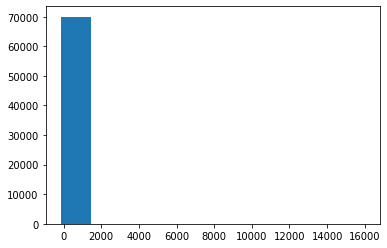

In [14]:
plt.hist(heart_data['ap_hi']) # viewing data disribution for ap_hi feature

(array([6.9766e+04, 2.1000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 3.0000e+00, 1.1000e+01, 4.0000e+00, 4.0000e+00]),
 array([  -70.,  1037.,  2144.,  3251.,  4358.,  5465.,  6572.,  7679.,
         8786.,  9893., 11000.]),
 <BarContainer object of 10 artists>)

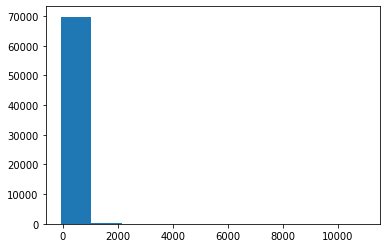

In [15]:
plt.hist(heart_data['ap_lo']) # viewing data distribution for ap_lo feature

These graphics visualize the extreme values that we saw with our summary statistics. Because the range of data points is so large, our data distribution is off. We know these values are not valid values, so we need to remove them and then check our distributions again.

The American College of Cardiology & American Heart Association's guidelines for blood pressure in adults. These values are a starting point for acceptable ranges for the data in the ap_hi and ap_lo fields. Further investigation into humanly possible systolic/diastolic blood pressure readings is needed to define appropriate ranges to clean up the dataset. This is an area where having access to someone with domain expertise (a cardiologist) would be helpful. We will use what is available to us on the internet and make an informed decision on appropriate ranges for values in both the ap_hi and ap_lo fields.
The following graphics are from Healthline:
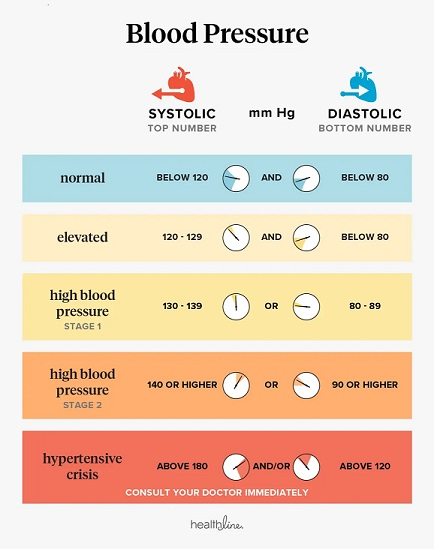


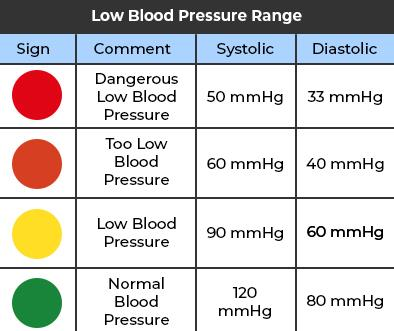

Using the information from the American Heart Association, we will remove instances with data that cannot be possible.

In [9]:
heart_data = heart_data.loc[heart_data['height'] > 3.5] # removing instances with outliers by setting the lower boundary for height at 3.5 feet accounting for dwarfism
heart_data = heart_data.loc[heart_data['weight'] > 70] # removing instances with outliers by setting lower boundary for weight at 70 lbs

In [10]:
heart_data = heart_data.loc[(heart_data['ap_hi']>50) & (heart_data['ap_hi']<250)] # removing instances with values outside of the range of viable values
heart_data = heart_data.loc[(heart_data['ap_lo']>30) & (heart_data['ap_lo']< 180)]

First iteration thru this process, the model was run using height and weight features independently. In an effort to improve the model,height and weight was combined into a new engineered feature, BMI (body mass index) which is a known predictor of health. This new feature did improve my model accuracy by about 1%

In [11]:
# converting weight and height into BMI measurement
heart_data['BMI'] = ((heart_data['weight']/heart_data['height']**2))*720 
# dropping BMI's outside of possible range
heart_data = heart_data.loc[heart_data['BMI']<=60] 
# dropping height and weight columns to reduce multicollinearity
heart_data = heart_data.drop(['weight', 'height'], axis = 1) 

In [19]:
heart_data.describe() # viewing the cleansed data set

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,68687.000000,68687.000000,68687.000000,68687.000000,68687.000000,68687.000000,68687.000000,68687.000000,68687.000000,68687.000000,68687.000000
mean,53.327482,0.348800,126.607903,81.370055,1.364829,1.226054,0.088037,0.053605,0.803325,0.494824,28.106389
std,6.761190,0.476594,16.749560,9.619786,0.679104,0.572027,0.283351,0.225239,0.397487,0.499977,5.322160
min,29.580000,0.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.547555
25%,48.380000,0.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,24.449904
50%,53.980000,0.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.983025
75%,58.420000,1.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.842568
max,64.970000,1.000000,240.000000,170.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,59.510811


(array([  143.,  4493., 27748., 20545., 10101.,  3827.,  1222.,   402.,
          128.,    78.]),
 array([12.54755541, 17.243881  , 21.94020659, 26.63653217, 31.33285776,
        36.02918334, 40.72550893, 45.42183452, 50.1181601 , 54.81448569,
        59.51081127]),
 <BarContainer object of 10 artists>)

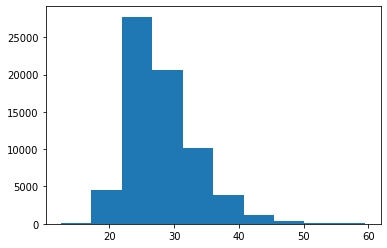

In [20]:
plt.hist(heart_data['BMI'])

(array([1.7000e+01, 1.1320e+03, 1.1377e+04, 3.7417e+04, 9.9400e+03,
        7.2080e+03, 1.3240e+03, 2.2100e+02, 4.3000e+01, 8.0000e+00]),
 array([ 60.,  78.,  96., 114., 132., 150., 168., 186., 204., 222., 240.]),
 <BarContainer object of 10 artists>)

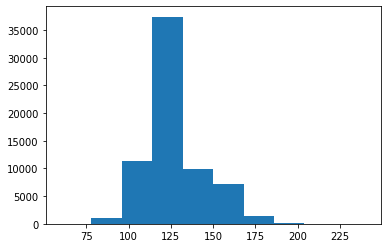

In [21]:
plt.hist(heart_data['ap_hi']) # checking distribution of data after removing outliers

(array([7.8000e+01, 2.8560e+03, 1.0708e+04, 4.9928e+04, 4.3680e+03,
        4.5100e+02, 2.4600e+02, 3.1000e+01, 8.0000e+00, 1.3000e+01]),
 array([ 40.,  53.,  66.,  79.,  92., 105., 118., 131., 144., 157., 170.]),
 <BarContainer object of 10 artists>)

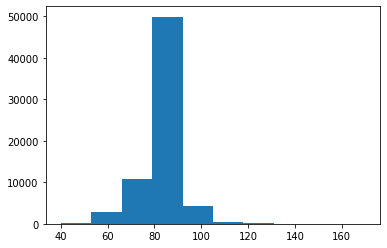

In [22]:
plt.hist(heart_data['ap_lo']) # checking distribution of data after removing outliers

With the outlier data removed, we now have better looking distributions. 

Below is the investigation into predictive power of creating a featured engineered column, 'high risk' using the ap_hi (systolic blood pressure) and age features in hopes of increasing the models accuracy. This new feature did not prove to improve the model's predictive power so it was eliminated. Code commented out for reference.

In [22]:
# df=heart_data[heart_data['cardio']>0] # creating dataframe of instances with cardiovasular disease

In [25]:
# df.describe()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,33988.000000,33988.000000,33988.000000,33988.000000,33988.000000,33988.000000,33988.000000,33988.000000,33988.000000,33988.0,33988.000000
mean,54.965217,0.352389,133.801930,84.637107,1.516829,1.278039,0.083412,0.051783,0.788308,1.0,29.132699
std,6.343075,0.477721,17.370371,9.803033,0.776819,0.625338,0.276508,0.221592,0.408514,0.0,5.550405
min,39.110000,0.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,12.547555
25%,50.390000,0.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0,25.056165
50%,55.850000,0.000000,130.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.0,28.094576
75%,60.010000,1.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.0,32.245200
max,64.970000,1.000000,240.000000,170.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.0,59.510811


In [29]:
heart_data['high_risk'] = 0 # creating new feature 'high_risk' and setting to false

In [30]:
# locating instances meeting high risk requirements and setting 'high_risk' feature to positive
heart_data.loc[(heart_data['ap_hi']>=130) & (heart_data['age']>50), 'high_risk'] = 1 

Let's use value_counts to check the distribution in my target feature. Since we have a classification problem, it is desirable for our target feature labels to be evenly distributed. This will help our classification model learn to distinguish between classes.

In [23]:
heart_data['cardio'].value_counts()

0    34699
1    33988
Name: cardio, dtype: int64

Good news! My target is nicely distributed which will be effective for training a model.

In [24]:
heart_data['cholesterol'].value_counts() # determining number of categories for cholesterol

1    51508
2     9299
3     7880
Name: cholesterol, dtype: int64

In [25]:
heart_data['gluc'].value_counts() # determining number of categories for glucose

1    58389
3     5229
2     5069
Name: gluc, dtype: int64

###Modeling

First lets look at correlation between our features to ensure we don't have features with high redundancy.

In [28]:
corr_matrix = heart_data.corr() # Finding correlation between features and target
corr_matrix["cardio"].sort_values(ascending=False)

cardio         1.000000
ap_hi          0.425085
ap_lo          0.336123
age            0.239733
cholesterol    0.221522
BMI            0.190853
gluc           0.089943
gender         0.007454
alco          -0.008008
smoke         -0.016155
active        -0.037393
Name: cardio, dtype: float64

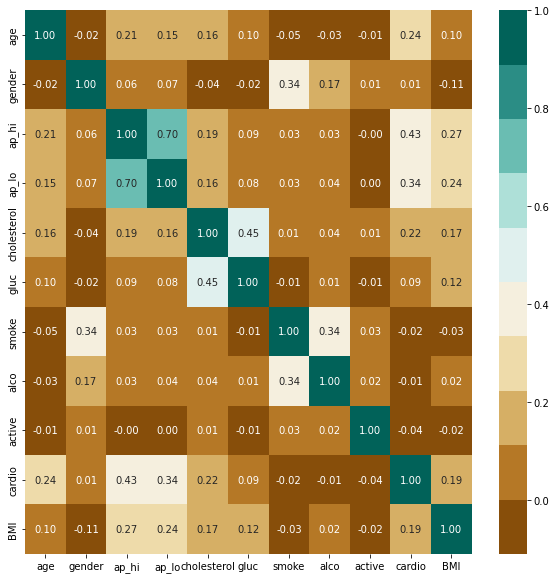

In [27]:
# Plot heatmap to visually show which features (if any) are correlated
fig, ax = plt.subplots(figsize=(10, 10))
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(corr_matrix, cmap=colormap, annot=True, fmt=".2f")
plt.show()

The heatmap shows that we have some correlation between ap_hi (systolic blood pressure) and ap_lo (diastolic blood pressure). This is to be expected as they are both a measure of blood pressure. But, they are both important individually. As such, I will keep all the features for initial machine learning modeling. The remaining features are not highly correlated which is beneficial for our classification machine learning model.

We are now ready to split our data into our feature matrix and our target data. Our target is the 'cardio' field. This field indicates positive (1) or negative (0) for heart disease for each instance.

In [12]:
X = heart_data.drop(['cardio'], axis = 1) # Dropping identified features and defining feature matrix
y = heart_data[['cardio']] # target feature 

In [13]:
X.columns #Verifying that columns were dropped in the feature matrix

Index(['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke',
       'alco', 'active', 'BMI'],
      dtype='object')

Our dataset has features that are of different scales ('weight' and 'alcohol' as an example). As such, we will normalize our data to transform our features to be on a similar scale. This improves the performance and training stability of the model.

In [14]:
Scaler = MinMaxScaler() # normalizing with the MinMaxScaler
X_scaled = Scaler.fit_transform(X) # fitting and transforming our feature data with the scaler

As mentioned in my intital EDA, I investigated whether my data needed to be normalized for use in my models. My iteration for model choice did return a message suggesting that I normalize my data when I attempted to train the models with the non normalized data. Therefore, for a better result, I will normalize my data before training the model(s).

We are now ready to split our data into training and testing sets.  We will use cross_val scores for the validation set, so I do not need a split for a separate validation set.

In [15]:
X_train,X_test, y_train,y_test = train_test_split(X_scaled,y, test_size = 0.20, random_state = 42) 

Now that the data is split between training and testing, let's take a look at our target values distribution to ensure they are well distributed. This will help our training model learn.

In [16]:
print(y_train.value_counts())
print(y_test.value_counts())

cardio
0         27836
1         27113
dtype: int64
cardio
1         6875
0         6863
dtype: int64


The distribution looks good. Now, on to training a model. The target is categorical so we will need a classification model. Logistic Regression is a good simple model which should be investigated. We will also want to look at DecisionTreeClassifier and more advanced Decision Tree Classifiers, such as RandomForestClassifier, AdaBoost, and GradientBoost. In order to look at several models in an efficient way, we will use a for loop to iterate through different classification models to find which one gives the best accuracy. We will also calculate a cross val score for each model. Comparing these values will give us insight into whether our model may be overfitting the data. Ideally the training set and cross-val scores will be similar.

In [17]:
# create a list of machine learning models to iterate thru
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(random_state=42),AdaBoostClassifier(random_state=42),GradientBoostingClassifier(random_state=42)]
for model in models: # iterate thru each model
  model.fit(X_train,y_train.values.ravel()) # train model on training data
  accuracy = model.score(X_train,y_train.values.ravel()) # find accuracy of model training set
  model_cv_score = cross_val_score(model, X_train, y_train.values.ravel(), cv=5) # calculate cross-val scores for model
  print(f'The', model, 'has an accuracy of ', round(accuracy*100,4),'%')
  print(f'The', model, 'has a cross-val score of ', round(model_cv_score.mean()*100,4),'%')



The LogisticRegression() has an accuracy of  72.7875 %
The LogisticRegression() has a cross-val score of  72.762 %
The DecisionTreeClassifier() has an accuracy of  99.9581 %
The DecisionTreeClassifier() has a cross-val score of  63.7519 %
The RandomForestClassifier(random_state=42) has an accuracy of  99.9454 %
The RandomForestClassifier(random_state=42) has a cross-val score of  70.5545 %
The AdaBoostClassifier(random_state=42) has an accuracy of  73.0623 %
The AdaBoostClassifier(random_state=42) has a cross-val score of  72.984 %
The GradientBoostingClassifier(random_state=42) has an accuracy of  73.7029 %
The GradientBoostingClassifier(random_state=42) has a cross-val score of  73.5154 %


Insights from model accuracy scores:


*   DecisionTreeClassifier and RandomForestClassifier seem to be overfitting the data. We know this because our training set accuracy as great as it is, can not be reproduced with cross validation or the testing data set. Although the RandomForestClassifier is overfitting, the cross-val and test set accuracy are closer to the training set accuracy than the DecisionTreeClassifier. Perhaps tuning the RandomForestClassifier hyperparameters will improve the overfitting.
*   GradientBoostingClassifier and LogisticRegression give very reproduceable results.GradientBoostingClassifier has slightly higher accuracy so we will attempt to tune the hyperparameters using GridSearchCV to see if we can increase the accuracy. 



GridSearchCV execution time can be long. We need to balance run time with potential model improvement. In an effort to make the execution time efficient, we will investigate tuning the generally more important hyperparameter for Decision Tree Classifiers. These are commonly accepted as n_estimators, max_depth and learning_rate. 

In [37]:
param_grid = { # setting the parameter grid
    "n_estimators": [10,25,50],
    "max_depth": [2,3,8],
    "learning_rate": [0.01,0.05,.08]

}
gb_class = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_class, param_grid, cv=5)
grid_search.fit(X_train, y_train.values.ravel()) # fitting grid search to our training data set

print('Best Parameters',grid_search.best_params_)
print('Best Score', grid_search.best_score_)

Best Parameters {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 50}
Best Score 0.733334583653055


Wow. That took some time to process. A few modifications needed to be made from my initial parameter grid. My initial parameter grid contained 5 parameters with 5 values each. The code would not execute before timing out. So I needed to go back and reduce the number of hyperparameters and values.

GridSearchCV found our best parameters from our chosen iterations gave a best score of 73.4%. The default hyperparameters for GradientBoostingClassifer gave a slightly better score. Therefore, we will use the default hyperparameters for our final model.

In [21]:
# model = GradientBoostingClassifier(random_state = 42, n_estimators = 500, learning_rate = 0.05,max_depth = 2) # model with recommended hyperparameters from GridSearchCV
model = GradientBoostingClassifier(random_state = 42)
model.fit(X_train,y_train.values.ravel()) # train tuned model on training data
accuracy = model.score(X_train,y_train.values.ravel())
model_cv_score = cross_val_score(model, X_train, y_train.values.ravel(), cv=5)
print(f'The', model, 'has an accuracy of ', accuracy)
print(f'The', model, 'has a cross-val score of ', model_cv_score.mean())


The GradientBoostingClassifier(random_state=42) has an accuracy of  0.7370288813263207
The GradientBoostingClassifier(random_state=42) has a cross-val score of  0.73515440993148


We will run a quick investigation of tuning hyperparameters for the RandomForestClassifier model to see if we can correct the overfitting we saw with the default hyperparameters. We will iterate thru max_depth values. 

In [18]:
max_depth_range = [4,8,10,12]
for md in max_depth_range:
  rf_classifier = RandomForestClassifier(n_estimators = 60, max_depth = md, random_state=42)
  rf_classifier.fit(X_train, y_train.values.ravel())
  rf_train_score = rf_classifier.score(X_train, y_train.values.ravel())
  rf_cross_val = cross_val_score(rf_classifier, X_train, y_train.values.ravel(), cv=5)
  print('The training set score is ',rf_train_score, 'for max_depth ', md)
  print('The cross-val score is' ,rf_cross_val.mean(), 'for max_depth', md)

The training set score is  0.7251815319660049 for max_depth  4
The cross-val score is 0.7251815915510182 for max_depth 4
The training set score is  0.7406140239130831 for max_depth  8
The cross-val score is 0.7332982051453388 for max_depth 8
The training set score is  0.7534259040200914 for max_depth  10
The cross-val score is 0.7340443181207513 for max_depth 10
The training set score is  0.7719157764472511 for max_depth  12
The cross-val score is 0.7340261214146564 for max_depth 12


The tuning of the hyperparameters did indeed reduce the overfitting for the RandomForestClassifier model. The accuracy is similar to the GradientBoostingClassifier accuracy, but GradientBoostingClassifier is slightly better. As such, we will move forward with the tuned GradientBoostingClassifier model.

###Evaluation


We will now evaluate our model with our reserved test set.

In [34]:
y_pred = model.predict(X_test) # using the trained model to make predictions on test data
accuracy = accuracy_score(y_test, y_pred) # finding test set accuracy
 # printing accuracy as percentage and rounded to two decimals
print('The test set accuracy score is ', round(accuracy*100,2), '%')
recall = recall_score(y_test, y_pred)
print('The recall score is : ', recall)
f1 = f1_score(y_test, y_pred) # finding the f1 score of test set
print('The f1 score is ', round(f1,2))
# predict probablities of positive class for test set
y_prob = model.predict_proba(X_test)[:,1] 
auc_roc = roc_auc_score(y_test, y_prob) # calculate AUC-ROC score
print('AUC-ROC Score: ', auc_roc)

The test set accuracy score is  73.43 %
The recall score is :  0.6897454545454546
The f1 score is  0.72
AUC-ROC Score:  0.8014165339832832


In [36]:
y_prob = model.predict_proba(X_test)[:,1]
threshold = 0.4
y_pred = (y_prob >=threshold).astype(int)
accuracy = accuracy_score(y_test, y_pred) # finding test set accuracy
 # printing accuracy as percentage and rounded to two decimals
print('The test set accuracy score is ', round(accuracy*100,2), '%')
recall = recall_score(y_test, y_pred)
print('The recall score is : ', recall)
f1 = f1_score(y_test, y_pred) # finding the f1 score of test set
print('The f1 score is ', round(f1,2))
auc_roc = roc_auc_score(y_test, y_prob) # calculate AUC-ROC score
print('AUC-ROC Score: ', auc_roc)

The test set accuracy score is  72.86 %
The recall score is :  0.7812363636363636
The f1 score is  0.74
AUC-ROC Score:  0.8014165339832832


In [31]:
conf_mx = confusion_matrix(y_test,y_pred) # using confusion matrix for visual of errors
print('Confusion Matrix')
print(conf_mx) # printing the matrix
# precision = precision_score(y_test,y_pred) # finding precision score of test set
# print('The precision score is ', round(precision,2)) # printing precision score rounded to two decimals

Confusion Matrix
[[5346 1517]
 [2133 4742]]


The test set accuracy score is 73.4%. This lines up nicely with our training set accuracy score of 73.7% and our cross-validation score of 73.5%

Let's also take a look at which features in our dataset our model found most important for predicting heart disease. 

In [39]:
feature_importances = model.feature_importances_ # using feature_importances

<Axes: >

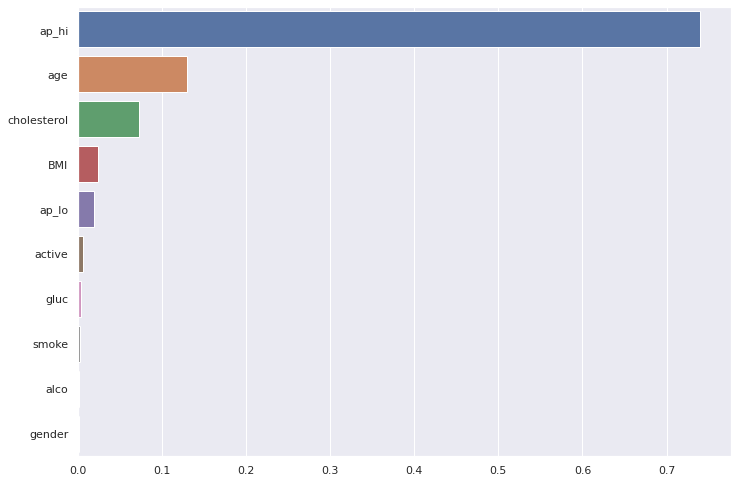

In [40]:
# Setting up a bar chart with feature importances
# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

This graphic shows that by in far, systolic blood pressure (ap_hi) is the most important feature in predicting heart disease. I find it interesting that diastolic blood pressure (ap_lo) is further down the order. I would be curious to know if we could get more detail on the behavioral features and use multi ordinal encoded values if any of those features would become more important in the machine learning model. With alcohol consumption and gender seeming to have little importance, I went back and reiterated thru the model with those features removed. Removing the features dropped my accuracy slightly, so I kept them in the feature matrix for the final model.

In [38]:
heart_data['cholesterol'].value_counts()

1    51508
2     9299
3     7880
Name: cholesterol, dtype: int64

###Results

 

The prediction accuracy of the model, about 73.5%, was not impressive but is a good starting point. The evaluation metrics indicate the model is reliable. The predictive power of this model is not at a level of being diagnostic, but it could possibly be used as a flag for further cardiovasular testing. 



In an effort to improve upon the models accuracy, I did additional feature engineering and combined the top predictors of systolic blood pressure and age to see if they would have more predictive power as one.  A new binary categorical feature labeled 'high_risk' was created. High risk was defined as systolic blood pressure over 130 and age greater than 50. These values were determined by analyzing data in these fields for instances where cardiovasular disease was present in addition to domain knowledge sources (American Heart ASsociation). This new feature did not improve the model's accuracy, therefore it was removed from the feature matrix for the final model.

In conclusion, I believe that I have maximized the predictive power of this particular dataset. More detailed data in the behavior features such as activity, smoking, alcohol use could give a better picture of overall health and may improve the model’s predictive ability. I would ask stakeholders for additional data to work with or if not available, recommend collecting additional data with amount of exercise per day, how many drinks per week, tobacco intake per day. 